In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yaswanthgali/sport-celebrity-image-classification

 34% 5.00M/14.8M [00:00<00:00, 28.7MB/s]
100% 14.8M/14.8M [00:00<00:00, 64.6MB/s]


In [ ]:
!unzip /content/sport-celebrity-image-classification.zip -d /content/

Archive:  /content/sport-celebrity-image-classification.zip
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(1).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(10).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(100).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(101).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(102).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(103).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(104).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(105).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(106).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(107).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(108).jpg  
  inflating: /content/Sports-celebrity images/Kane Williamson/kane_(109).j

In [ ]:
!pip install scikeras

Importing libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from tensorflow.keras import layers,Sequential,callbacks,models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter('always', FitFailedWarning)

In [7]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [8]:
data_dir = '/content/Sports-celebrity images'
img_size = 256
batch_size = 32
df = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                         image_size=(img_size, img_size),
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         seed=seed_value)
#we put the images togeter

NotFoundError: ignored

In [5]:
classes = df.class_names
classes

NameError: ignored

In [ ]:
#batch size:Number of images in a pack
len(df)
#len(df)*batch_size=14*32->448(about # of files)

14

In [ ]:
for image_batch, label_batch in df.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 256, 256, 3)
(32,)


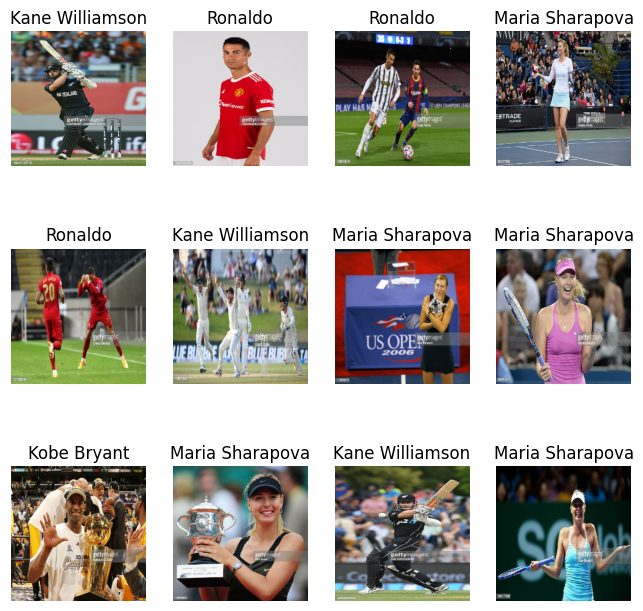

In [ ]:
plt.figure(figsize=(8,8))
for image_batch, label_batch in df.take(1):
  for i in range(12):
    ax=plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(classes[label_batch[i]])
    plt.axis('off')

**HYPERPARAMETER OPTIMIZATION MODEL**

In [ ]:
def train_test_split(data,train_split=.7,val_split=.25,
                     test_split=.05,shuffle=True,shuffle_size=10000):

    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=17)

    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)

    train_data=data.take(train_size)
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)

    return train_data,val_data,test_data

train_data,val_data,test_data=train_test_split(df)

print("Len of train:{}".format(len(train_data)))
print("Len of val:{}".format(len(val_data)))
print("Len of test:{}".format(len(test_data)))

Len of train:9
Len of val:3
Len of test:2


In [ ]:
datagen = ImageDataGenerator(rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.3,
                             brightness_range=[.2,.5],
                             horizontal_flip=True)

for X_batch, y_batch in train_data:
  for i in range(3):
    augmented_images, augmented_labels = next(datagen.flow(X_batch, y_batch, batch_size=3))
    X_batch = np.concatenate((X_batch, augmented_images), axis=0)
    y_batch = np.concatenate((y_batch, augmented_labels), axis=0)


train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
channels=3
input_shape=(img_size,img_size,channels)

model=models.Sequential([layers.Conv2D(32,(3,3),activation="relu",
                                       input_shape=input_shape),
                                       layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation="relu"),
                                       layers.MaxPooling2D((2,2)),
                         layers.Dropout(.5),
                         layers.Conv2D(64,(3,3),activation="relu"),
                                       layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation="relu"),
                                       layers.MaxPooling2D((2,2)),
                         layers.Dropout(.5),
                         layers.Conv2D(64,(3,3),activation="relu"),
                                       layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation="relu"),
                                       layers.MaxPooling2D((2,2)),
                         layers.Flatten(),
                         layers.Dense(64,activation="relu"),
                         layers.Dense(len(classes),activation="softmax")
                        ])

model.build(input_shape=input_shape)

In [ ]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

The line of code you provided is using the EarlyStopping callback from Keras. This callback is used during the training process of a neural network to stop the training process early if a certain condition is met. Specifically, it monitors a specified metric (in this case, 'val_loss', which is the validation loss) and stops the training process if the metric does not improve after a certain number of epochs (defined by patience).

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, epochs=200, verbose=1, batch_size=batch_size, validation_data = val_data, callbacks=[early_stopping])

Epoch 1/200
9/9 [==============================] - 21s 372ms/step - loss: 23.0281 - accuracy: 0.2384 - val_loss: 2.0084 - val_accuracy: 0.2188
Epoch 2/200
9/9 [==============================] - 1s 111ms/step - loss: 3.0743 - accuracy: 0.2206 - val_loss: 1.3892 - val_accuracy: 0.3542
Epoch 3/200
9/9 [==============================] - 1s 105ms/step - loss: 1.4931 - accuracy: 0.2918 - val_loss: 1.3570 - val_accuracy: 0.3333
Epoch 4/200
9/9 [==============================] - 1s 104ms/step - loss: 1.3827 - accuracy: 0.3310 - val_loss: 1.3595 - val_accuracy: 0.3542
Epoch 5/200
9/9 [==============================] - 1s 105ms/step - loss: 1.3271 - accuracy: 0.3488 - val_loss: 1.3389 - val_accuracy: 0.3333
Epoch 6/200
9/9 [==============================] - 1s 104ms/step - loss: 1.3250 - accuracy: 0.3416 - val_loss: 1.3311 - val_accuracy: 0.4792
Epoch 7/200
9/9 [==============================] - 1s 105ms/step - loss: 1.2644 - accuracy: 0.3737 - val_loss: 1.3085 - val_accuracy: 0.4167
Epoch 8/200

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Sports_celeb_class/my_model.h5')

In [2]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Sports_celeb_class/my_model.h5')

Text(0.5, 1.0, 'Training and Validation Loss')

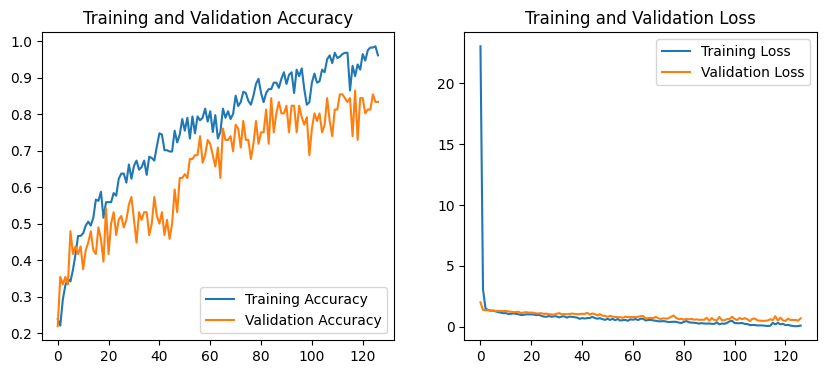

In [ ]:
history.params['epochs'] = 127
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(range(history.params["epochs"]),
         history.history["accuracy"],
         label="Training Accuracy")

plt.plot(range(history.params["epochs"]),
         history.history["val_accuracy"],
         label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)

plt.plot(range(history.params["epochs"]),
         history.history["loss"],
         label="Training Loss")

plt.plot(range(history.params["epochs"]),
         history.history["val_loss"],
         label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

In [ ]:
def predicts(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=classes[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)

    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


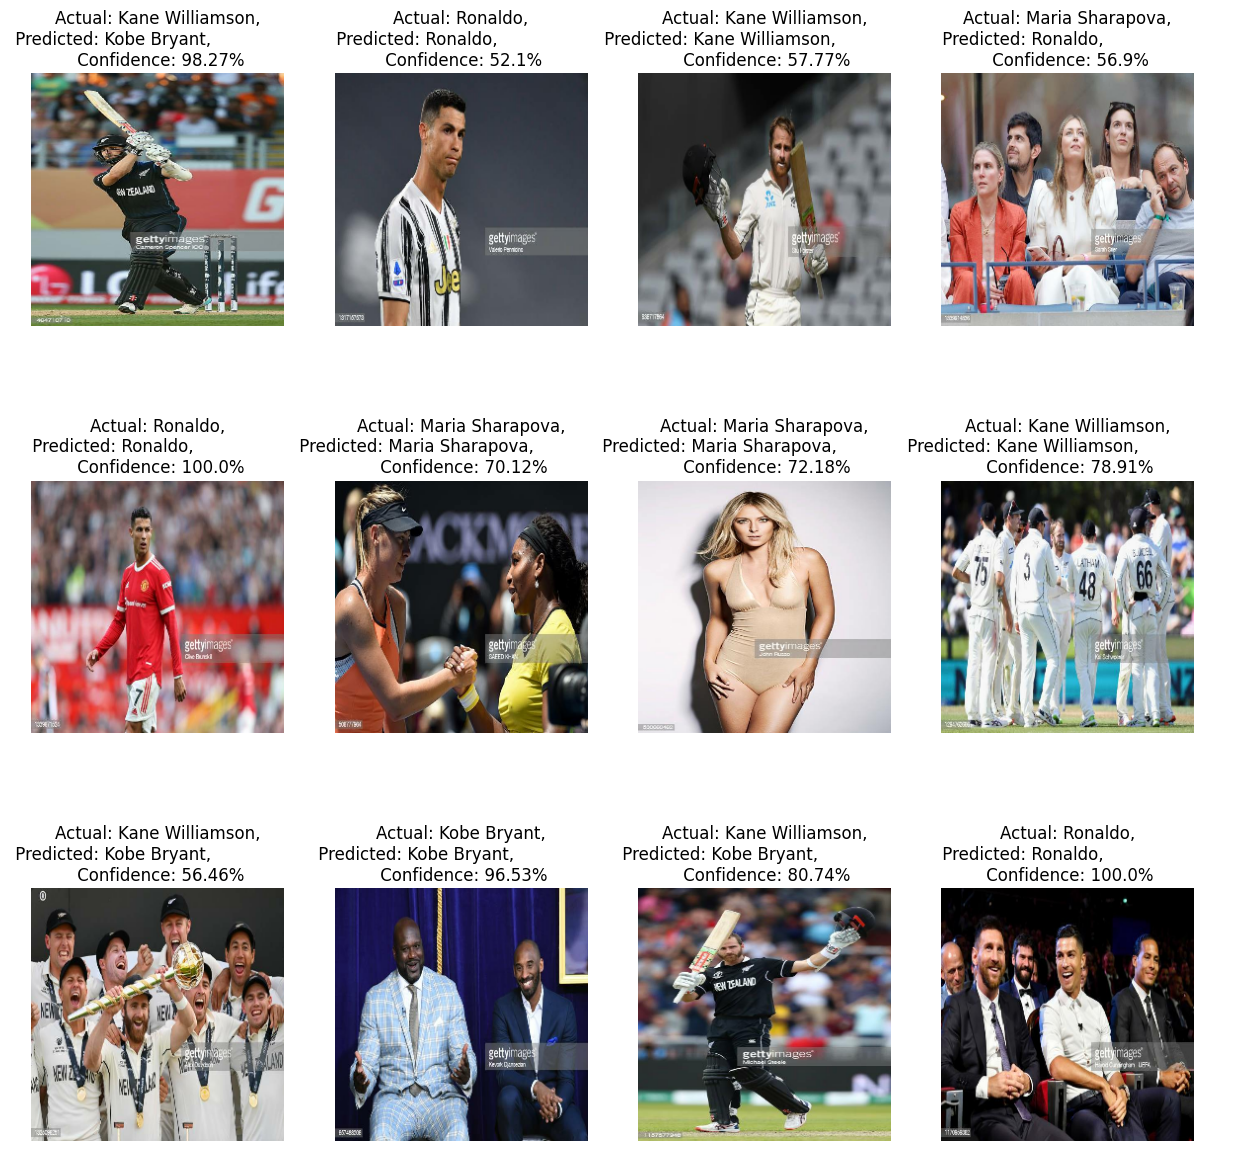

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predicts(model,images[i].numpy())
        actual_class=classes[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\
                  \n Confidence: {confidence}%")
        plt.axis("off")

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img_size = 256
batch_size = 32

# Define the function for predictions
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Get image path from user input
img_path = input('Enter image path: ')

# Load and preprocess the image
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(img_size, img_size)
)

# Make predictions
predicted_class, confidence = predict(loaded_model, img)

# Display the image and predictions
plt.figure(figsize=(2, 3))
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence}%")
plt.axis("off")
plt.show()


Enter image path: /content/vk.png
1/1 [==============================] - 0s 54ms/step


NameError: ignored